In [1]:

import json
import torch
import json
import torch
from torchvision import models, transforms
from PIL import Image
import torchvision.transforms.functional as TF
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import torch.nn.functional as F
# dev for scaling

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn.functional as F



import numpy as np

import torchvision.transforms as T
from PIL import Image


from transformers import AutoFeatureExtractor, AutoModel

from PIL import Image
import requests
from torchvision import models, transforms
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image


2024-07-25 13:47:41.321449: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-25 13:47:41.345032: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-25 13:47:41.695817: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


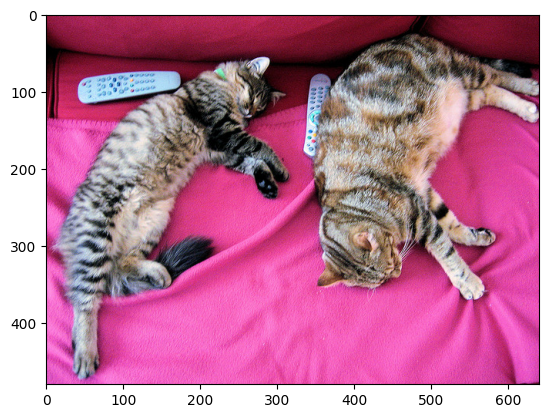

In [2]:
# Load the image from the URL
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
plt.imshow(image)
plt.show()

# pretrained on Imagenet

https://huggingface.co/docs/transformers/v4.16.2/en/model_doc/vit

In [2]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state,

print(last_hidden_states[0].shape)

#embeddings = last_hidden_states[:, 0].cpu()


transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize(int((256 / 224) * feature_extractor.size["height"])),
        T.CenterCrop(feature_extractor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
    ]
)

/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


torch.Size([1, 197, 768])


tensor([[1.0000, 0.5649, 0.5878,  ..., 0.4920, 0.5608, 0.5516],
        [0.5649, 1.0000, 0.7916,  ..., 0.7129, 0.7613, 0.7480],
        [0.5878, 0.7916, 1.0000,  ..., 0.6384, 0.6633, 0.6658],
        ...,
        [0.4920, 0.7129, 0.6384,  ..., 1.0000, 0.9235, 0.9208],
        [0.5608, 0.7613, 0.6633,  ..., 0.9235, 1.0000, 0.9560],
        [0.5516, 0.7480, 0.6658,  ..., 0.9208, 0.9560, 1.0000]],
       grad_fn=<MmBackward0>)


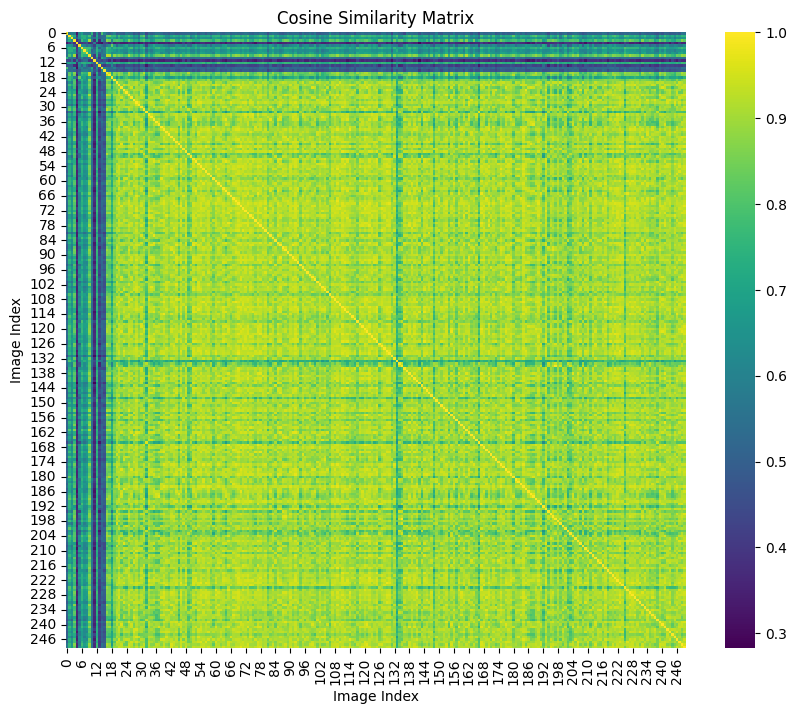

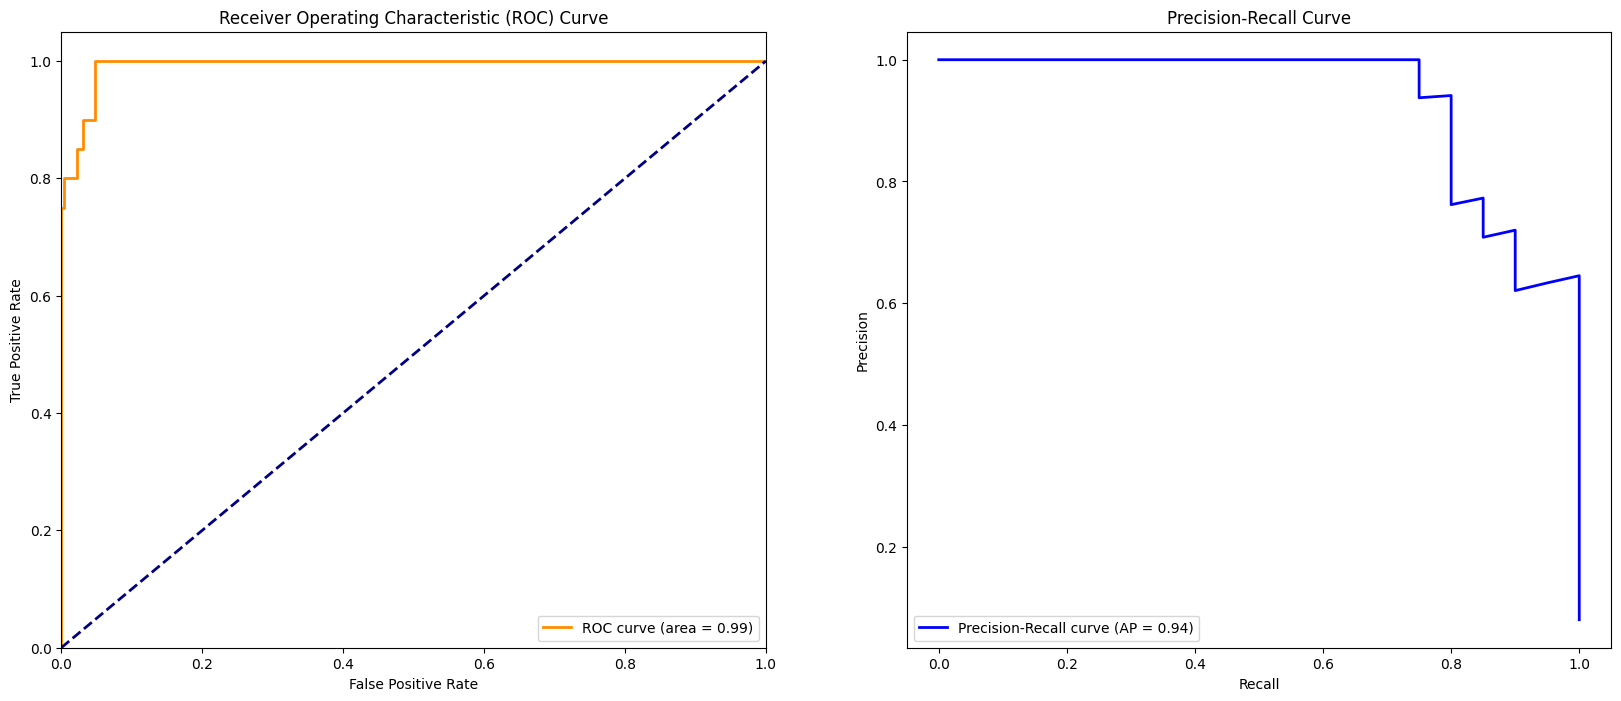

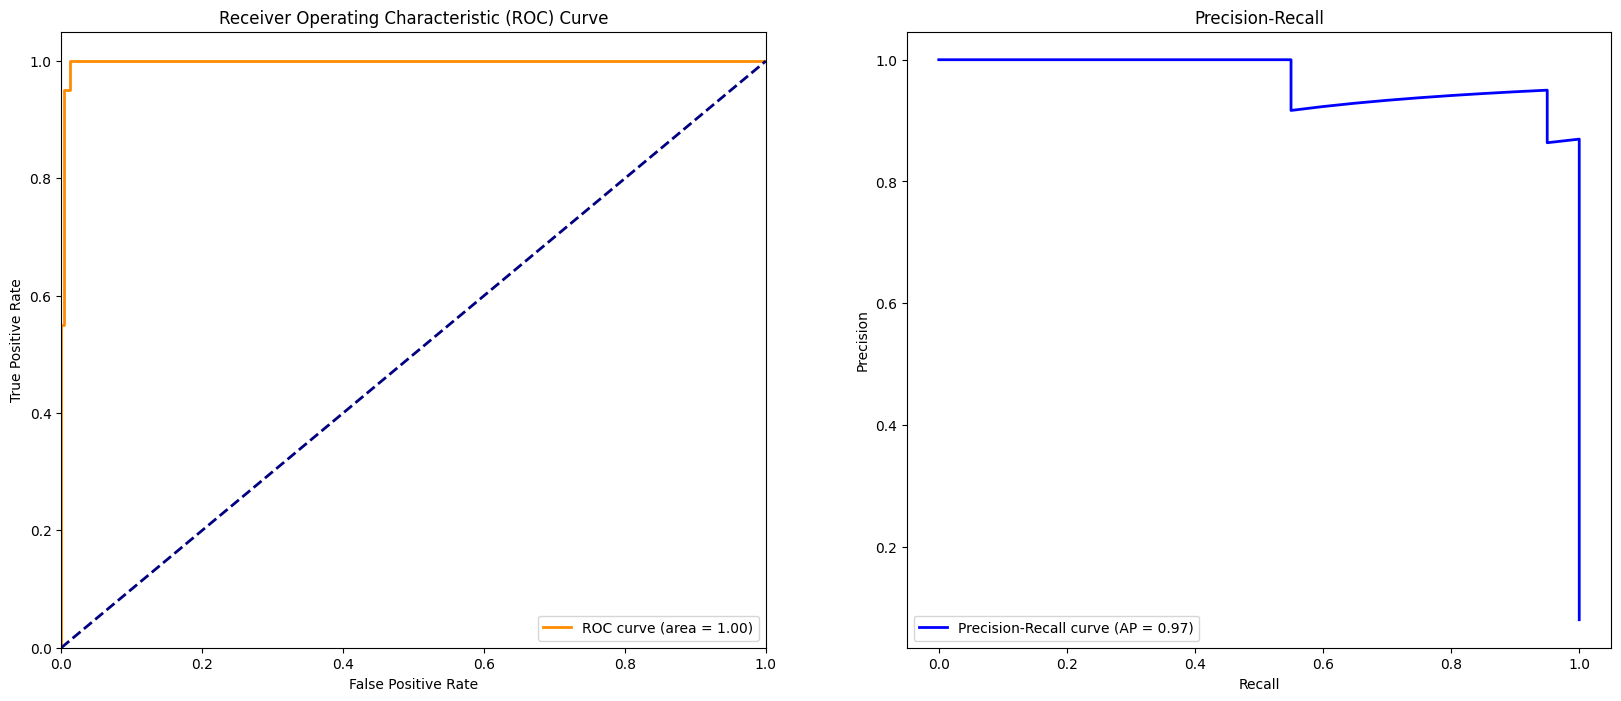

: 

In [6]:
path='/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_1-tile/experiment_paths.json'

with open(path, 'r') as file:
    experiment = json.load(file)
    

labels=np.array([0 if 'good' in path else 1 for path in experiment['train']])

paths=experiment['train']

indexes_1 = np.where(labels == 1)[0]
indexes_0 = np.where(labels == 0)[0]
index_conc=np.concatenate((indexes_1,indexes_0))

img_list_reorder=[paths[i] for i in index_conc]
images = []

for filename in img_list_reorder:
    img = Image.open(filename)
    if img.mode == 'L':  # Check if the image is grayscale (single channel)
        img = img.convert('RGB')  # Convert grayscale to RGB (three channels)
    images.append(img)
    
images=[transformation_chain(image) for image in images] 
images=torch.stack(images)
embeddings = model(images).last_hidden_state[:, 0].cpu()
embeddings = F.normalize(embeddings, p=2, dim=1)

# Calculate cosine similarity matrix
cosine_similarity_matrix = torch.mm(embeddings, embeddings.t())

print(cosine_similarity_matrix)

# Plot the similarity matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_similarity_matrix.detach().numpy(), cmap="viridis")
plt.title("Cosine Similarity Matrix")
plt.xlabel("Image Index")
plt.ylabel("Image Index")
plt.show()

# Calculate column sums of the MSE matrix
col_sums = np.sum(cosine_similarity_matrix.detach().numpy(), axis=0)

# Normalize the sorted column sums
scaler = MinMaxScaler()
colsums_sorted = scaler.fit_transform(col_sums.reshape(-1, 1)).flatten()
colsums_sorted=1-colsums_sorted
labels=[1]*len(indexes_1) + [0]*len(indexes_0)


# Calculate precision, recall, and ROC AUC
precision, recall, _ = precision_recall_curve(labels, colsums_sorted)
average_precision = average_precision_score(labels, colsums_sorted)
fpr, tpr, _ = roc_curve(labels, colsums_sorted)
roc_auc = auc(fpr, tpr)

# Plot ROC curve and Precision-Recall curve side by side
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# ROC curve
ax[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[0].legend(loc="lower right")

# Precision-Recall curve
ax[1].plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve')
ax[1].legend(loc="lower left")

plt.show()


import numpy as np
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt

embeddings_=embeddings.detach().numpy()

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
outlier_labels = lof.fit_predict(embeddings_)
anomaly_scores = -lof.negative_outlier_factor_


precision, recall, _ = precision_recall_curve(labels, anomaly_scores)
average_precision = average_precision_score(labels, anomaly_scores)
fpr, tpr, _ = roc_curve(labels, anomaly_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve and Precision-Recall curve side by side
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# ROC curve
ax[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[0].legend(loc="lower right")

# Precision-Recall curve
ax[1].plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall' )
ax[1].legend(loc="lower left")



plt.show()

# pretrainend on beans dataset

In [ ]:
model_ckpt = "nateraw/vit-base-beans"
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
hidden_dim = model.config.hidden_size
# Data transformation chain.
transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize(int((256 / 224) * extractor.size["height"])),
        T.CenterCrop(extractor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

images=[image]

images=[transformation_chain(image) for image in images]
images=torch.stack(images)
outputs = model(images)


last_hidden_states = outputs.last_hidden_state

print(last_hidden_states[0].shape)

embeddings = last_hidden_states[:, 0].cpu()



/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of ViTModel were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([197, 768])


tensor([[1.0000, 0.6050, 0.5337,  ..., 0.5452, 0.5572, 0.5689],
        [0.6050, 1.0000, 0.6797,  ..., 0.5331, 0.5552, 0.6146],
        [0.5337, 0.6797, 1.0000,  ..., 0.7467, 0.7481, 0.7658],
        ...,
        [0.5452, 0.5331, 0.7467,  ..., 1.0000, 0.9766, 0.9395],
        [0.5572, 0.5552, 0.7481,  ..., 0.9766, 1.0000, 0.9574],
        [0.5689, 0.6146, 0.7658,  ..., 0.9395, 0.9574, 1.0000]],
       grad_fn=<MmBackward0>)


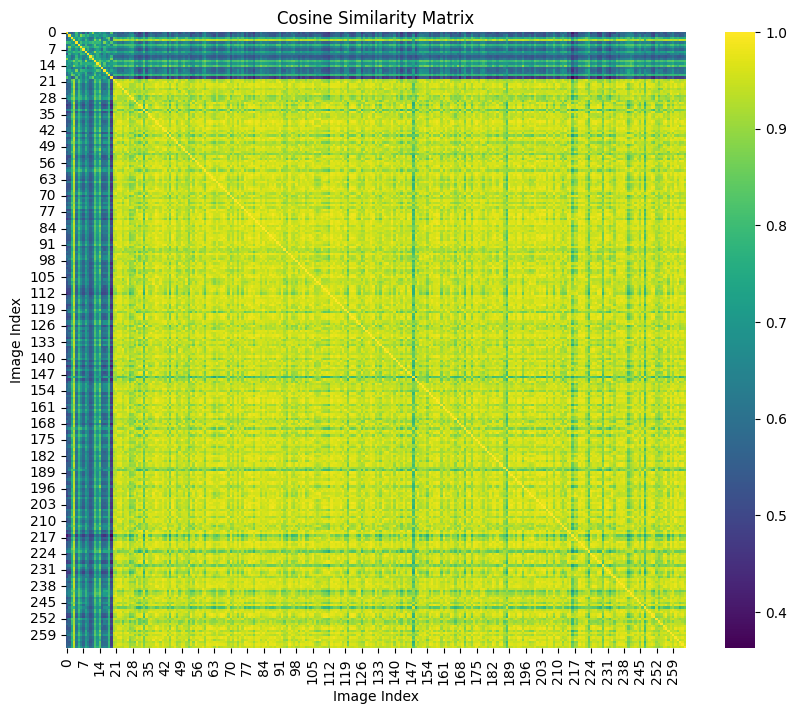

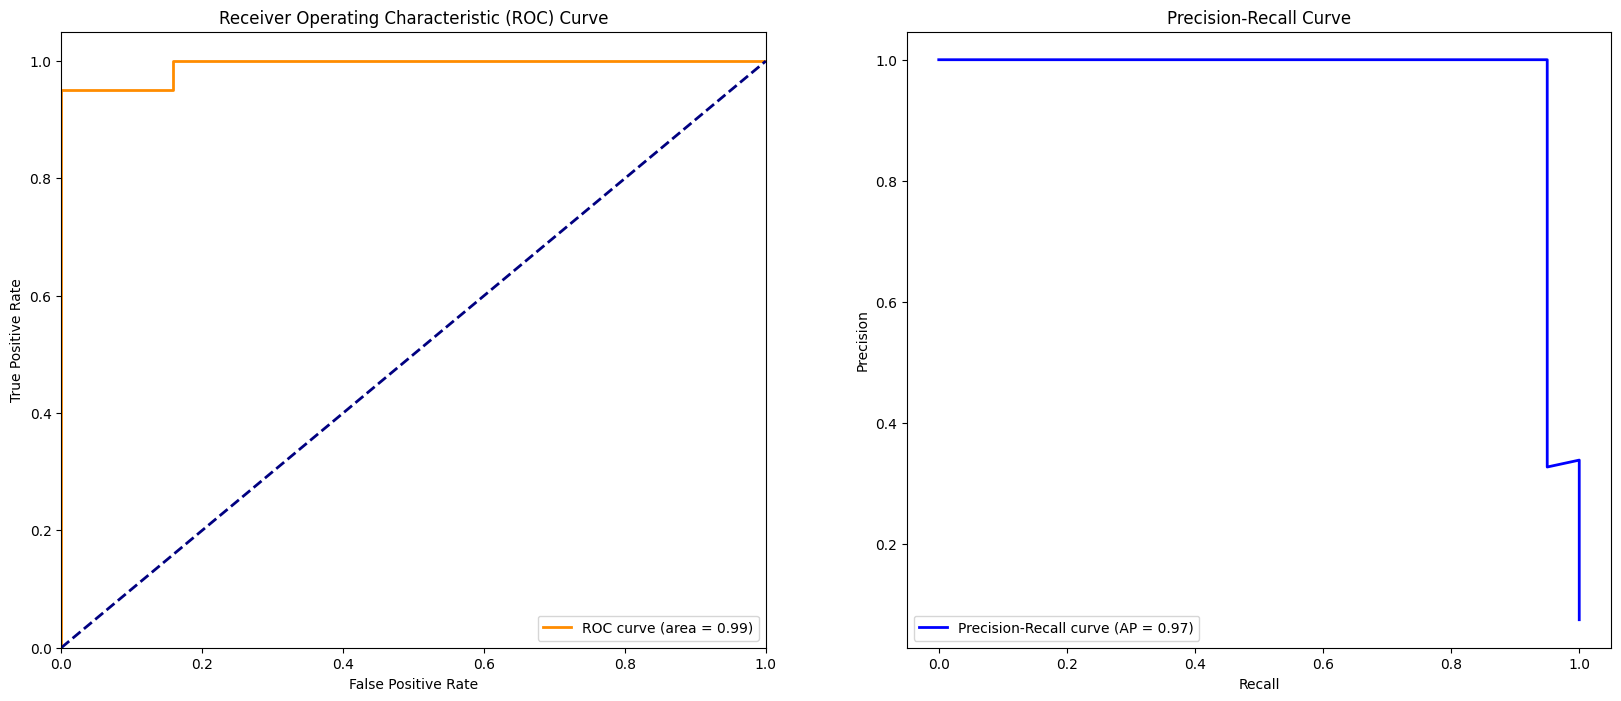

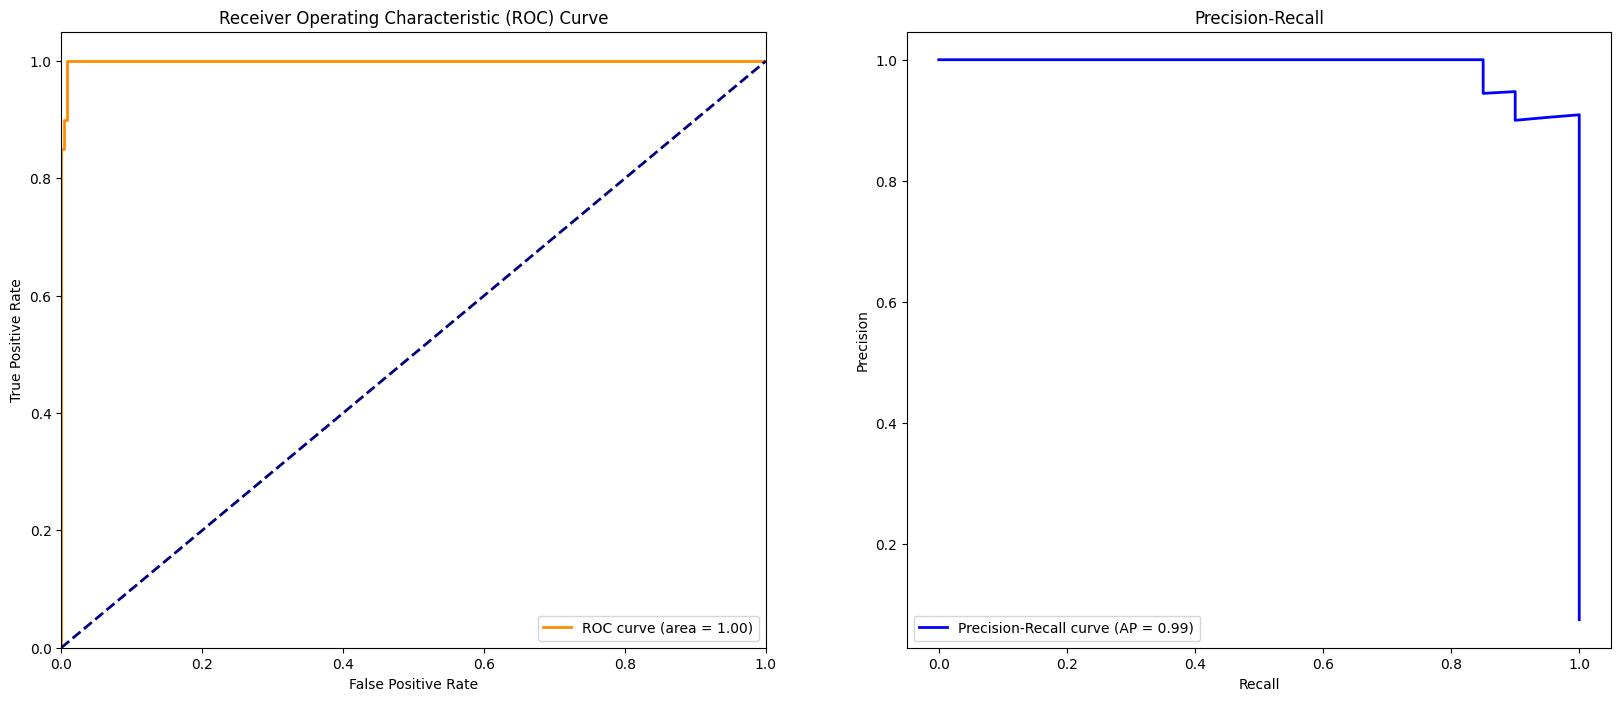

In [ ]:
path='/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_1-leather/experiment_paths.json'

with open(path, 'r') as file:
    experiment = json.load(file)
    

labels=np.array([0 if 'good' in path else 1 for path in experiment['train']])

paths=experiment['train']

indexes_1 = np.where(labels == 1)[0]
indexes_0 = np.where(labels == 0)[0]
index_conc=np.concatenate((indexes_1,indexes_0))

img_list_reorder=[paths[i] for i in index_conc]
images = []

for filename in img_list_reorder:
    img = Image.open(filename)
    if img.mode == 'L':  # Check if the image is grayscale (single channel)
        img = img.convert('RGB')  # Convert grayscale to RGB (three channels)
    images.append(img)
    
images=[transformation_chain(image) for image in images] 
images=torch.stack(images)
embeddings = model(images).last_hidden_state[:, 0].cpu()
embeddings = F.normalize(embeddings, p=2, dim=1)

# Calculate cosine similarity matrix
cosine_similarity_matrix = torch.mm(embeddings, embeddings.t())

print(cosine_similarity_matrix)

# Plot the similarity matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_similarity_matrix.detach().numpy(), cmap="viridis")
plt.title("Cosine Similarity Matrix")
plt.xlabel("Image Index")
plt.ylabel("Image Index")
plt.show()

# Calculate column sums of the MSE matrix
col_sums = np.sum(cosine_similarity_matrix.detach().numpy(), axis=0)

# Normalize the sorted column sums
scaler = MinMaxScaler()
colsums_sorted = scaler.fit_transform(col_sums.reshape(-1, 1)).flatten()
colsums_sorted=1-colsums_sorted
labels=[1]*len(indexes_1) + [0]*len(indexes_0)


# Calculate precision, recall, and ROC AUC
precision, recall, _ = precision_recall_curve(labels, colsums_sorted)
average_precision = average_precision_score(labels, colsums_sorted)
fpr, tpr, _ = roc_curve(labels, colsums_sorted)
roc_auc = auc(fpr, tpr)

# Plot ROC curve and Precision-Recall curve side by side
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# ROC curve
ax[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[0].legend(loc="lower right")

# Precision-Recall curve
ax[1].plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve')
ax[1].legend(loc="lower left")

plt.show()


import numpy as np
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt

embeddings_=embeddings.detach().numpy()

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
outlier_labels = lof.fit_predict(embeddings_)
anomaly_scores = -lof.negative_outlier_factor_


precision, recall, _ = precision_recall_curve(labels, anomaly_scores)
average_precision = average_precision_score(labels, anomaly_scores)
fpr, tpr, _ = roc_curve(labels, anomaly_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve and Precision-Recall curve side by side
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# ROC curve
ax[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[0].legend(loc="lower right")

# Precision-Recall curve
ax[1].plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall' )
ax[1].legend(loc="lower left")



plt.show()